# Example: Calculating the Scalp Coupling Index

This notebook calculates the Scalp Coupling Index[1] metric for assessing the signal quality of a recording.


[1] L. Pollonini, C. Olds, H. Abaya, H. Bortfeld, M. S. Beauchamp, and J. S. Oghalai, “Auditory cortex activation to natural speech and simulated cochlear implant speech measured with functional near-infrared spectroscopy,” Hearing Research, vol. 309, pp. 84–93, Mar. 2014, doi: 10.1016/j.heares.2013.11.007.


In [1]:
import cedalion
import cedalion.nirs
import cedalion.xrutils as xrutils
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path

xr.set_options(display_expand_data=False)

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [2]:
DATADIR = "../../data/BIDS-NIRS-Tapping"

In [3]:
subjects  = [f"sub-{i:02d}" for i in [1,2,3,4,5]]

# store data of different subjects in a dictionary
data = {} 
for subject in subjects:
    
    elements = cedalion.io.read_snirf(
        os.path.join(DATADIR, f"{subject}/nirs/{subject}_task-tapping_nirs.snirf")
    )

    amp = elements[0].data[0]

    amp = amp.pint.dequantify().pint.quantify("volts") # work around missing units in snirf file

    stim = elements[0].stim # pandas Dataframe
    geo3d = elements[0].geo3d
    
    # cedalion registers an accessor (attribute .cd ) on pandas DataFrames
    stim.cd.rename_events( {
        "1.0" : "control",
        "2.0" : "Tapping/Left",
        "3.0" : "Tapping/Right"
    })
    
    dpf = xr.DataArray([6, 6], dims="wavelength", coords={"wavelength" : amp.wavelength})
    
    data[subject] = xr.Dataset(
        data_vars = {
            "amp" : amp,
            "geo" : geo3d
        },
        attrs={"stim" : stim}, # store stimulus data in attrs
        coords={"subject" : subject} # add the subject label as a coordinate
    )

In [4]:
data["sub-01"]

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt
Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.0824899918305801 3.5272652784690273e-09 -8.985265795291575e-10] [6.534060185275914e-12 0.11404663614484922 -8.956669156345853e-09] [0.08248999697928468 3.893090638057428e-09 4.766247813092761e-10] [-0.04018770669918394 0.044642295725887106 0.12357659157001165] [-0.04174110787598461 0.007685839199884737 0.13437743644514044] [-0.05885642692737942 0.026136335712672674 0.11745327806321545] [0.03851939726517181 0.03078283979366837 0.1281798987708399] [-0.052808259274512416 0.06188780045911764 0.10403189889709587] [-0.06922421433143165 0.04108974212744533 0.0972095427514579] [-0.07351067792317667 0.05556043944468993 0.07592438053279707] [0.031418413207589764 0.05609701242391968 0.12112072355182572] [-0.05798909959739463 -0.013176608236818512 0.12293491786782985] [-0.07419549041066105 0.00549319711704184 0.10669158774707252] [0.023828589288117673 0.003996293896988853 0.14081960191362605] [-0.08184195746940305 0.022098763709400317 0.08422485645365857] [-0.08309090979477994 0.03520830182778492 0.0610323268526085] [0.026425335781627597 0.043375220063173334 0.12939415639453739] [0.035781770725957916 0.04568049698512951 0.12354633505671649] [0.037556277679295876 0.008001190852073497 0.134555406719549] [0.054080633753515184 0.026705026363902817 0.11818464121484251] [0.06801076312164317 0.02284818084680601 0.10445872040876931] [0.0481712114118228 0.062034828924799924 0.10518292837437133] [0.06461419274656584 0.042329086589563227 0.0977770136200937] [0.06967032405092426 0.05604290375898291 0.07590918892077606] [0.07526945345643418 0.037578919664336574 0.08007431341875021] [0.05288202968424921 -0.012139614237985343 0.12430811820847815]

## Calculating the SCI

From the paper:

> Since the LED sources at 760 nm and 850 nm were co-located, an optical channel in good contact with the scalp exhibited a prominent synchronous cardiac pulsation in both photodetected signals. This observation was independent of the
> amplitude of the output voltage of the photodetector, which in turn depends on the inter-distance between sources and detector. For each channel, we filtered both photodetected signals between 0.5 and 2.5 Hz to preserve only the cardiac
> component and normalized the resulting signals to balance any difference between their amplitude. Then, we computed the cross-correlation and we extracted the value at a time lag of 0 to quantify the similarity between the filtered 
> signals. In-phase and counter-phase identical waveforms yielded a zero-lag cross-correlation value of 1 and +1 respectively, whereas a null value derived from totally uncorrelated signals. Therefore, the zero-lag cross-correlation
> between photodetected signals of the same channel was used as a quantitative measure of the signal-to-noise ratio of the channel. We termed this value the scalp coupling index (SCI).


### 0. Utilities

In [5]:
def plot_channel(array, channel, ylabel, xlabel="time", tmin=1000, tmax=1030):
    f, ax = p.subplots(1,1, figsize=(12,4))
    ax.plot(array.time, array.sel(channel=channel, wavelength=760), "r-")
    ax.plot(array.time, array.sel(channel=channel, wavelength=850), "b-")
    p.xlim(tmin, tmax)
    p.xlabel(xlabel)
    p.ylabel(ylabel)

### 1. Bandpass filter to extract the cardiac signal

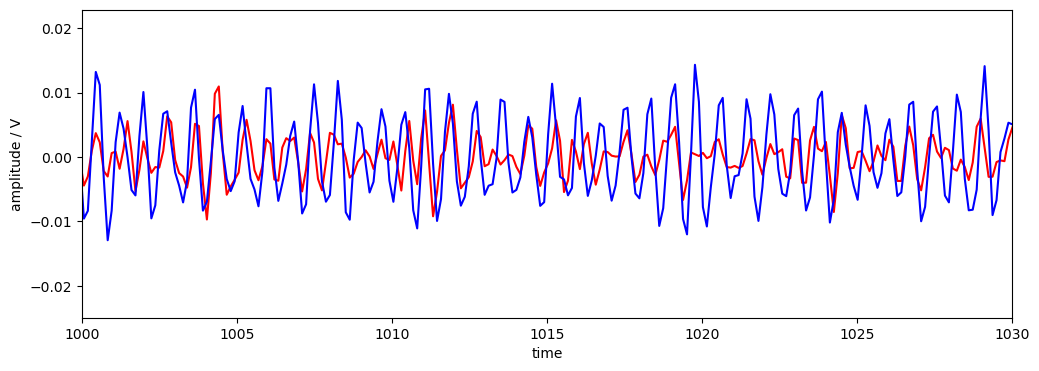

In [6]:
amp = data["sub-01"]["amp"]
amp_filtered = amp.cd.freq_filter(0.5, 2.5, butter_order=4)

plot_channel(amp_filtered, "S5D7", "amplitude / V")


### 2. Normalize filtered amplitudes

Subtract the mean and normalize to each channels standard deviation.

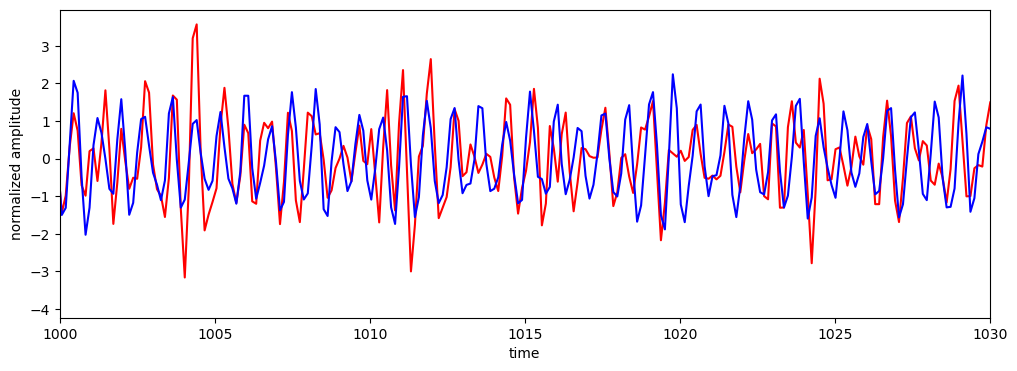

In [7]:
amp_filtered_normed = (amp_filtered - amp_filtered.mean("time")) / amp_filtered.std("time")
#amp_filtered_normed = (amp_filtered - amp_filtered.min("time")) / (amp_filtered.max("time") - amp_filtered.min("time"))

plot_channel(amp_filtered_normed, "S5D7", "normalized amplitude")

### 3. Moving windows

Calculate non-overlapping, moving windows of 2 seconds

In [8]:
window_len_s = 10 # seconds
window_len_samples = int(np.ceil(window_len_s * amp_filtered_normed.cd.sampling_rate))
print(f"A {window_len_s} second window is {window_len_samples} samples long.")

A 10 second window is 79 samples long.


<xarray.DataArray 'amp' (channel: 28, wavelength: 2, time: 295, window: 79)>
[] nan nan nan nan nan nan nan ... -0.2572 0.854 1.033 0.01559 -0.9137 -0.7821
Coordinates:
  * time        (time) float64 0.0 10.11 20.22 ... 2.953e+03 2.963e+03 2.973e+03
    samples     (time) int64 0 79 158 237 316 ... 22910 22989 23068 23147 23226
  * wavelength  (wavelength) float64 760.0 850.0
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector    (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'
    subject     <U6 'sub-01'
Dimensions without coordinates: window

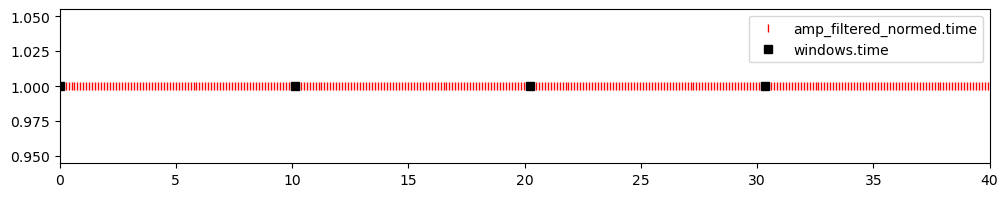

In [9]:
# this creates a new DataArray with a new dimension "window", that is window_len_samples large
# the time dimension will contain the time of the first sample in the window
# setting the stride size to the same value aus the window length will result in non-overlapping windows
windows = amp_filtered_normed.rolling(time=window_len_samples).construct("window", stride=window_len_samples)

display(windows)

f,ax = p.subplots(1,1, figsize=(12,2))
p.plot(amp_filtered_normed.time, np.ones(len(amp_filtered_normed.time)), "r|", label="amp_filtered_normed.time")
p.plot(windows.time, np.ones(len(windows.time)), "ks", label="windows.time")
p.xlim(0,40)
p.legend();

### 4. Calculate the correlation coefficient for each window

The cross-correlation of two time series $X$ and $Y$ at time lag $\tau$ is:

$$ \rho_{XY}(\tau) = \frac{E \left[(X_t - \mu_X)\cdot (Y_{t+\tau} - \mu_Y) \right] }{\sigma_X \sigma_Y} $$

In [10]:
sci = (windows - windows.mean("window")).prod("wavelength").sum("window") / window_len_samples
sci /= windows.std("window").prod("wavelength")
display(sci)

Magnitude,[[inf 0.651808346993398 0.504517775422922 ... 0.6714136649983805 0.3042146516294477 0.6381021738957295] [inf 0.7406054110712211 0.8120513550003908 ... 0.7437576064467213 0.6536248345831008 0.762916159593834] [inf 0.5827036790237397 0.5275362050188812 ... 0.5961474459280529 0.5552950195339813 0.6287932859102219] ... [inf 0.9402293639355199 0.923889863193029 ... 0.938946428613415 0.9190130768432166 0.9285091440742812] [inf 0.9784069940424428 0.964942845973496 ... 0.9557559229535788 0.9666101681415541 0.9631075073017143] [inf 0.9609702281968745 0.9580887342791364 ... 0.9622734452280202 0.9443117046758553 0.9329479640343884]]
Units,dimensionless


### 5. Illustrate heat maps of SCIs for the whole recording and all channels

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


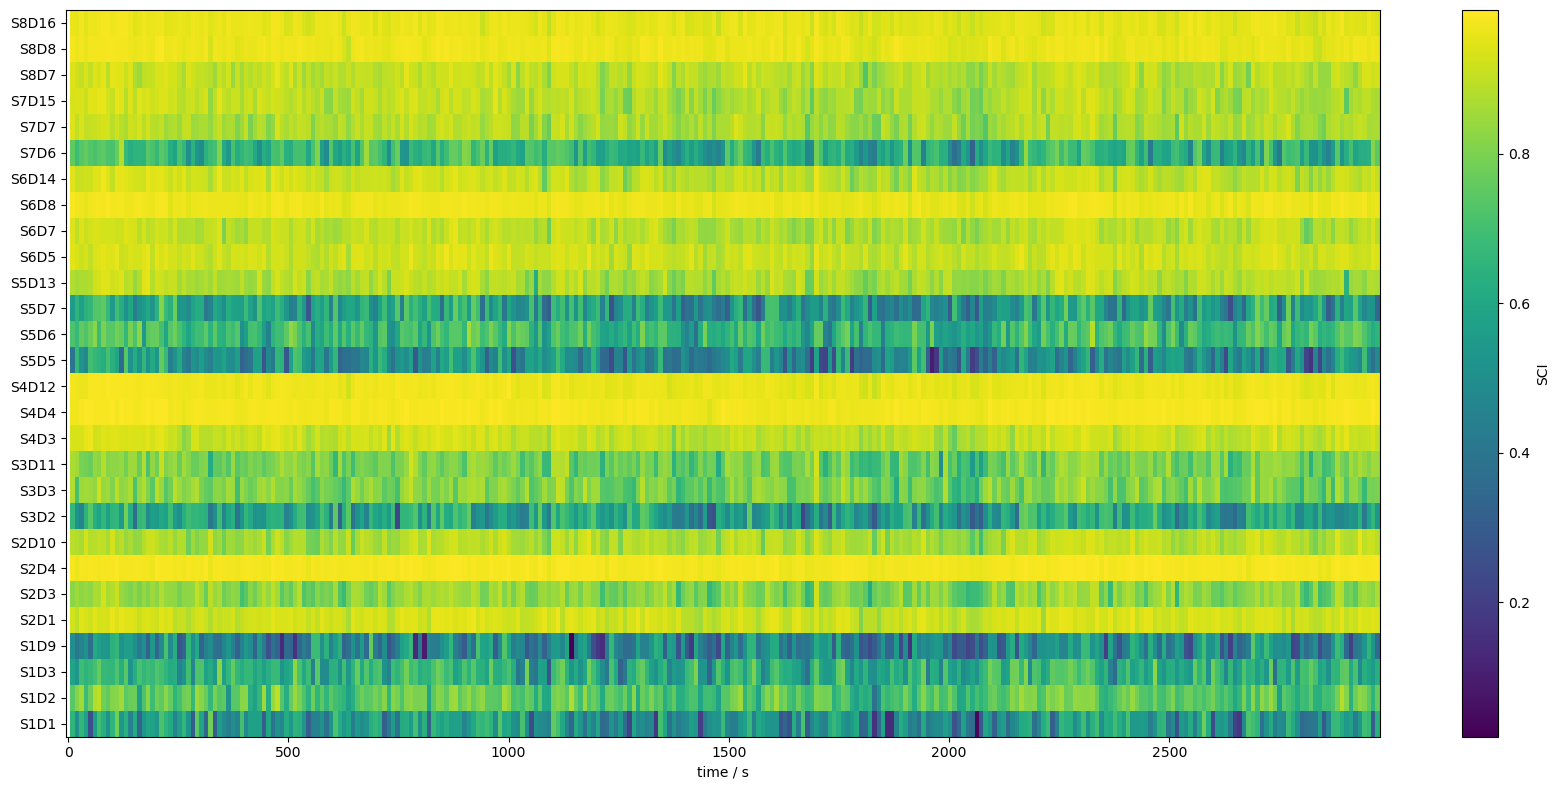

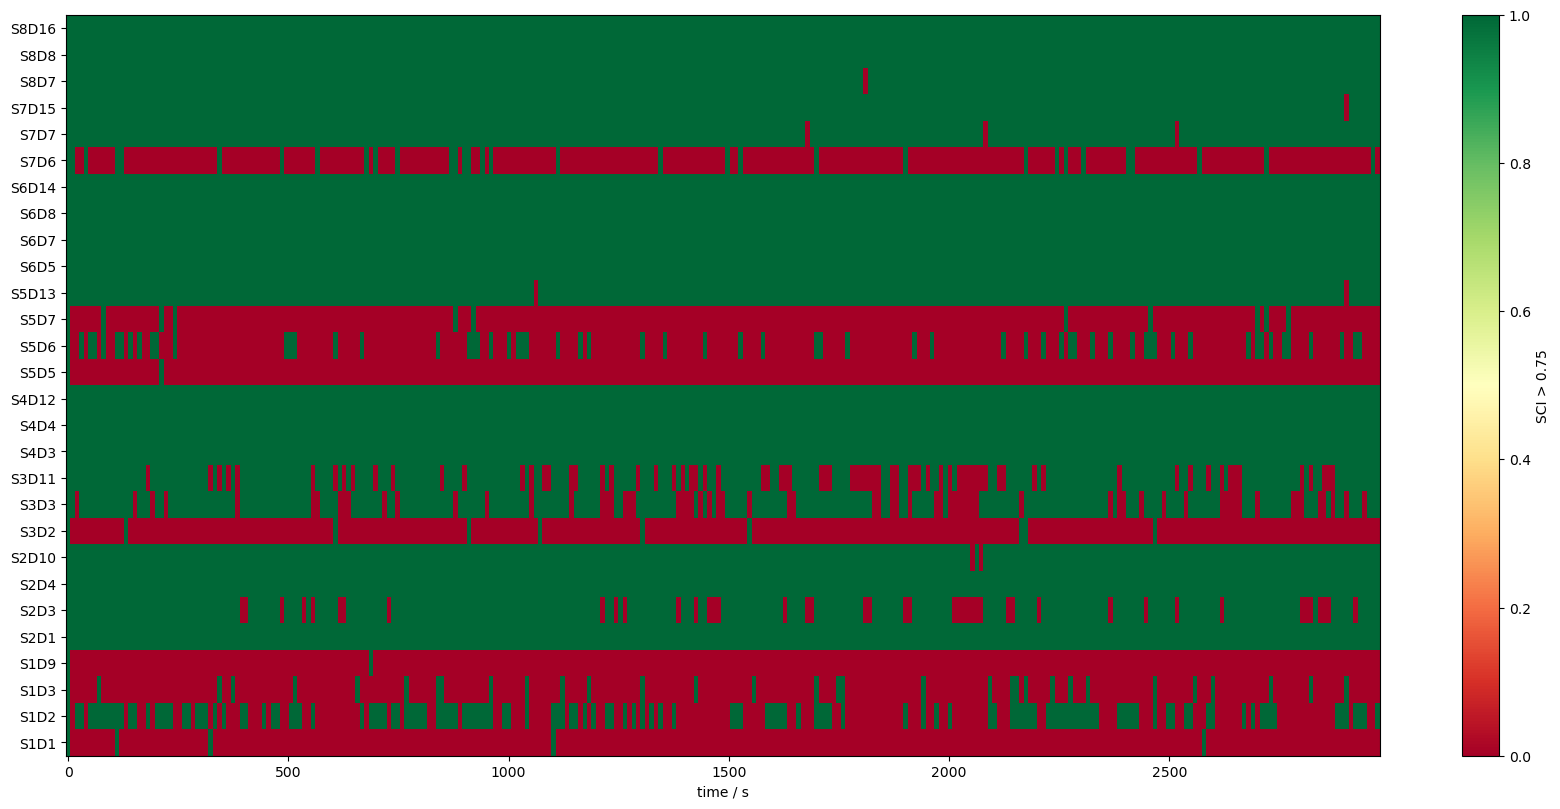

In [11]:
f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci, shading="nearest")
cb = p.colorbar(m, ax=ax)
cb.set_label("SCI")
ax.set_xlabel("time / s")
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(sci.channel)))
ax.yaxis.set_ticklabels(sci.channel.values);

f,ax = p.subplots(1,1,figsize=(17,8))

m = ax.pcolormesh(sci.time, np.arange(len(sci.channel)), sci>0.75, shading="nearest", cmap="RdYlGn")
cb = p.colorbar(m, ax=ax)
p.tight_layout()
ax.yaxis.set_ticks(np.arange(len(sci.channel)))
ax.yaxis.set_ticklabels(sci.channel.values);
cb.set_label("SCI > 0.75")
ax.set_xlabel("time / s");


### 6. Inspect time courses of good and bad channels

S3D3: SCI < 0.75 around t=2000s

S3D11: SCI < 0.75 around t=2000s

S6D5: SCI > 0.75 for all samples

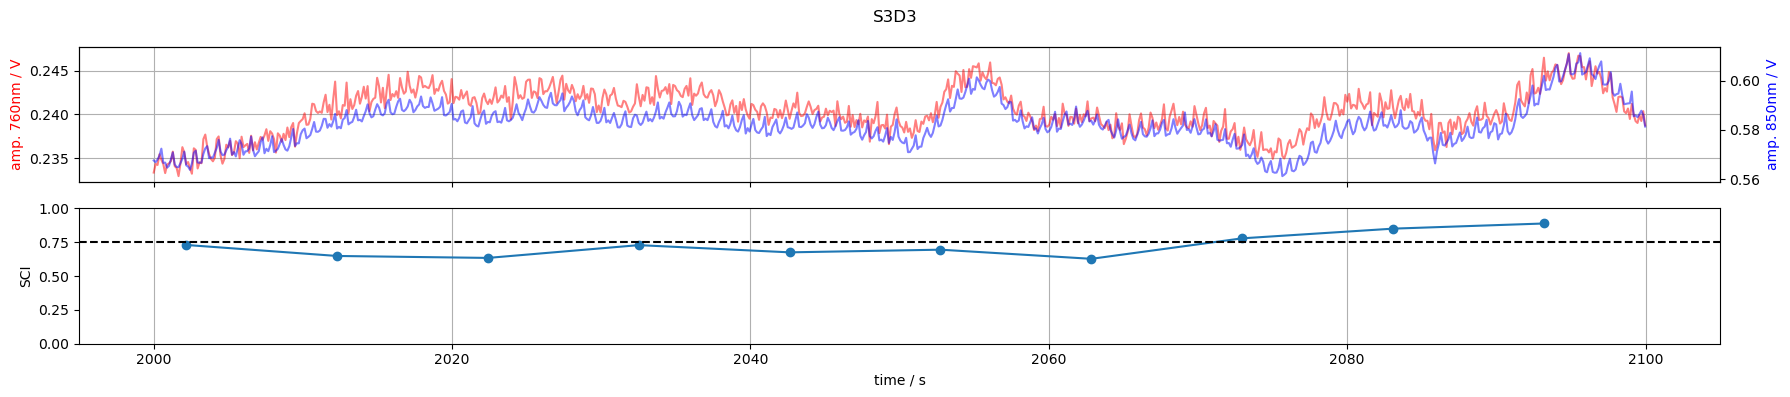

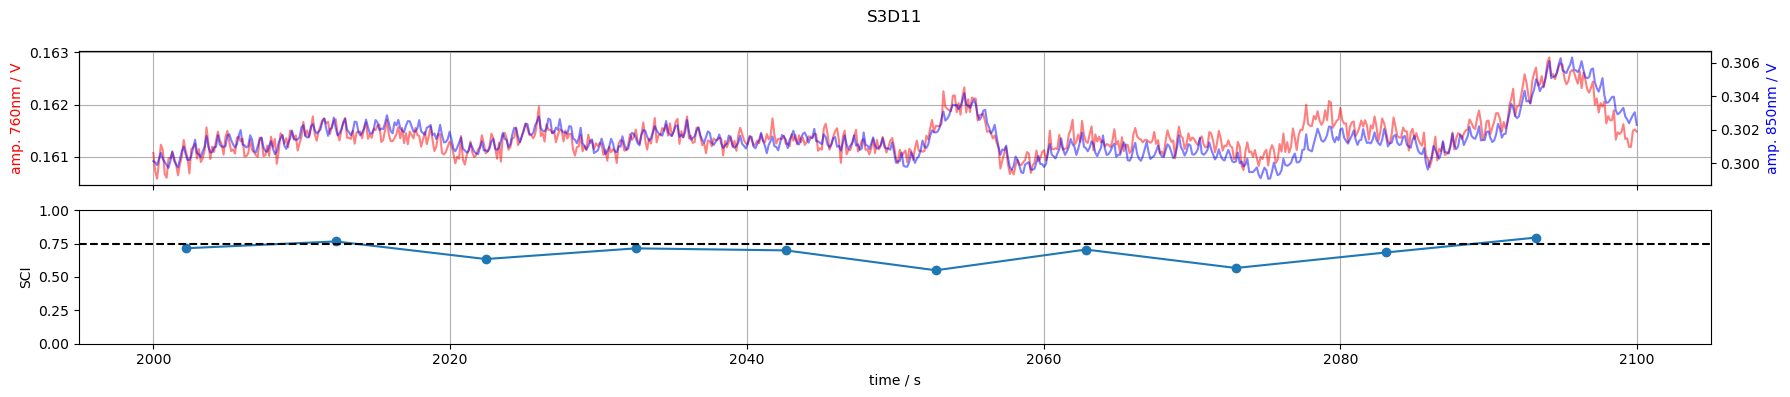

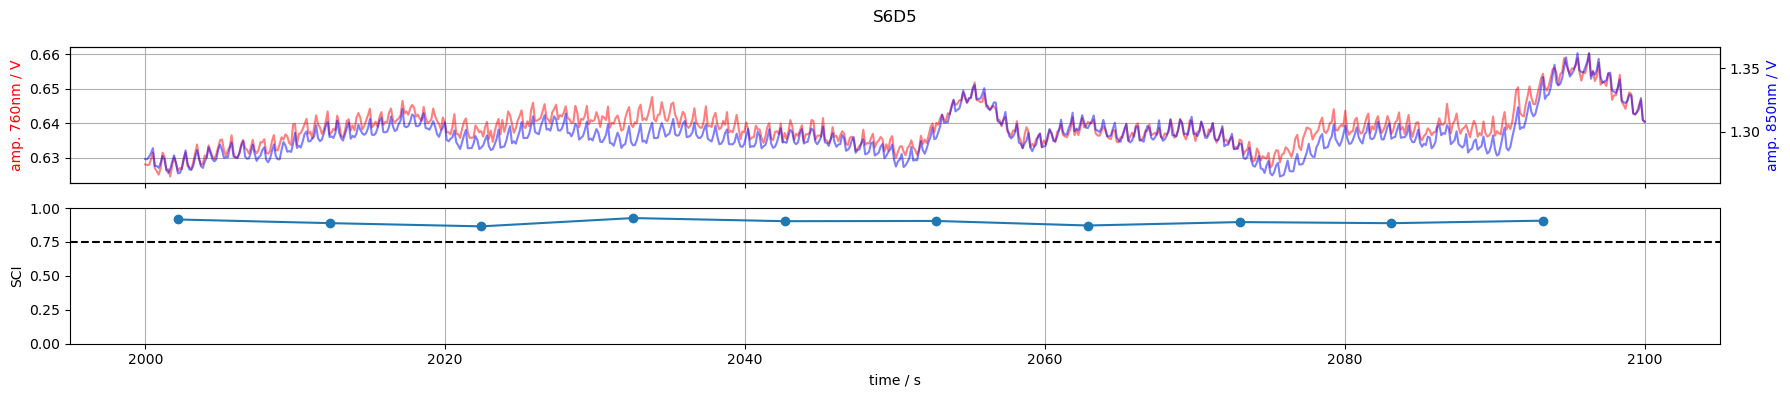

In [12]:
for channel in ["S3D3", "S3D11", "S6D5"]:
    tmin, tmax  = 2000, 2100
    f,ax = p.subplots(2,1, figsize=(18,4), sharex=True)

    m = (tmin <= amp.time) & (amp.time <= tmax)
    ax[0].plot(amp.time[m], amp.sel(channel=channel, wavelength=760, time=m), "r-", alpha=.5)
    ax[0].set_ylabel("amp. 760nm / V", color="r")
    ax2 =ax[0].twinx()
    ax2.plot(amp.time[m], amp.sel(channel=channel, wavelength=850, time = m), "b-", alpha=.5)
    ax2.set_ylabel("amp. 850nm / V", color="b")

    m = (tmin <= sci.time) & (sci.time <= tmax)
    ax[1].plot(sci.time[m], sci.sel(channel=channel, time=m), "-o")
    ax[1].set_ylabel("SCI")
    ax[1].set_xlabel("time / s")
    ax[1].axhline(0.75, c="k", ls="--")
    ax[1].set_ylim(0,1)

    ax[0].grid(1)
    ax[1].grid(axis="x")

    f.suptitle(channel)
    f.set_tight_layout(True)